In [2]:
import argparse                                                                                                                                                                                             
import os, sys
from glob import glob
                                                                                                                                                                                                            
import matplotlib.pyplot as plt  
f = plt.figure()
plt.close()
import mplhep as hep   
plt.style.use(hep.style.CMS)
plt.rcParams['figure.facecolor'] = 'white'

import numpy as np    
import pandas as pd
import yaml                                                                                                                                                                                                 
import json                                                                                                                                                                                                 

In [3]:
def load_json(fname):
    with open(fname) as f:
        plot = json.load(f)
        return plot

# Combined function for scalings and turnons

In [4]:
def remap_nano_key(key):
    if "StaMu" in key: key = key.replace("StaMu","gmtMuon")

#     print("before", key)

    if "L1puppiJetSC4sums:HT" in key:
        key = key.replace("L1puppiJetSC4sums:HT","seededConePuppiHT:default")
    if "L1puppiJetSC4sums:MHT" in key:
        key = key.replace("L1puppiJetSC4sums:MHT","seededConePuppiMHT:default")
        
    if "nnPuppiTau" in key:
        key = key.replace("nnPuppiTau","nnTau")
        
    if "L1puppiHistoJetSums:HT" in key:
        key = key.replace("L1puppiHistoJetSums:HT","phase1PuppiHT:default")
    if "L1puppiHistoJetSums:MHT" in key:
        key = key.replace("L1puppiHistoJetSums:MHT","phase1PuppiMHT:default")

    if "L1TrackHT:HT" in key:
        key = key.replace("L1TrackHT:HT","trackerHT:default")
    if "L1TrackHT:MHT" in key:
        key = key.replace("L1TrackHT:MHT","trackerMHT:default")
    if "L1TrackMET" in key:
        key = key.replace("L1TrackMET","trackerMET")
    if "L1TrackJet" in key:
        key = key.replace("L1TrackJet","trackerJet")
        
    if "puppiJetHisto" in key: key = key.replace("puppiJetHisto","phase1PuppiJet")
    if "puppiJetSC4" in key: key = key.replace("puppiJetSC4","seededConePuppiJet") 
#     if "L1caloJet" in key: key = key.replace("puppiJetHisto","phase1PuppiJet")

    key = key.replace("L1","")
#     print("after", key)

    return key

def comp_plots(nano_plot,menu_plot, sfxs = ["v22","v27"], ptype = "turnon",
               lss = ["-","--"], keys = None, markers = ["o","s"]):
    
    fig, axs = plt.subplots(2,1,figsize=(10, 12),
                            sharex = True,
                            gridspec_kw={'height_ratios': [3, 1]})  
    hep.cms.label(ax=axs[0], llabel="Phase-2 Simulation", rlabel = "14 TeV")

    if keys is None: keys = nano_plot.keys()
    # clean keys
    clean_keys = []
    for key in keys:
        if key in ['xlabel', 'ylabel', 'watermark']: 
            continue
        if key not in nano_plot.keys():
            print(f"Warning: {key} not in plot 1 keys. Skipping...")
            continue
        if remap_nano_key(key) not in menu_plot.keys():
            print(menu_plot.keys())
            print(f"Warning: {key} not in plot 2 keys. Skipping...")
            continue
        clean_keys.append(key)
        
#     if ptype == "rate":
#         xval_str = "x_values"
#         yval_str = "y_values"
#     else:
#         xval_str = "xvals"
#         yval_str = "yvals"
        
        
    for j,key in enumerate(clean_keys):
        ## plot 1
        plots = [nano_plot[key],menu_plot[remap_nano_key(key)]]
        color = f"C{j}"

        for i,p1 in enumerate(plots):
            sfx = sfxs[i]
            label = f"{sfx}, {p1['label']}"

            if ptype == "scalings":
                axs[0].plot(p1["xvals"],p1["yvals"], color = color, marker = markers[i],
                            label = label, ls = lss[i], mfc="none" if i == 1 else color)
            elif ptype == "rate":
                axs[0].plot(p1["x_values"],p1["y_values"], color = color, marker = markers[i],
                            label = label, ls = lss[i], mfc="none" if i == 1 else color)
            elif ptype == "turnon":
                p1["err_kwargs"]["marker"] = markers[i]
                p1["err_kwargs"]["xerr"] = None

                axs[0].errorbar(p1["xbins"],p1["efficiency"], yerr = p1["efficiency_err"], 
                            label = label, ls = lss[i], color = color, mfc="none" if i == 1 else color,
                            **(p1["err_kwargs"])
                               )
        
        ## Make ratios
        if ptype == "scalings":
            d_p1 = dict(zip(plots[0]["xvals"],plots[0]["yvals"]))
            d_p2 = dict(zip(plots[1]["xvals"],plots[1]["yvals"]))
        elif ptype == "rate":
            d_p1 = dict(zip(plots[0]["x_values"],plots[0]["y_values"]))
            d_p2 = dict(zip(plots[1]["x_values"],plots[1]["y_values"]))
        elif ptype == "turnon":
            d_p1 = dict(zip(plots[0]["xbins"],plots[0]["efficiency"]))
            d_p2 = dict(zip(plots[1]["xbins"],plots[1]["efficiency"]))
            
            # add 100% eff line
#             axs[0].axhline(1,ls = ":", alpha = 0.5, c = "k")
            
        df_p1 = pd.Series(d_p1)
        df_p2 = pd.Series(d_p2)
        
#         ax = axs[1]

        if (df_p1.sum()!=0) and (df_p1.sum()!=0):

            diff = (df_p1 - df_p2) 
            if ptype == "rate":
                diff /= df_p2
            label = p1["label"].split(",")[0]
            
            diff.plot(ax = axs[1], color = color, label = label)#, marker = ".", color = color)
#             axs[1].errorbar(p1["xbins"],df_p1 - df_p2,
#                             yerr = np.hypot(plots[0]["efficiency_err"], plots[1]["efficiency_err"]),
#                             label = label, marker = ".", color = color
# #                             label = label, ls = lss[i], color = color, mfc="none" if i == 1 else color,
# #                             **(p1["err_kwargs"])
#                            )
            if ptype == "turnon":
                if len(plots[0]["efficiency_err"][0]) != len(plots[1]["efficiency_err"][0]): continue
                y_err =  np.hypot(plots[0]["efficiency_err"][0], plots[1]["efficiency_err"][0])
                if len(diff) != len(y_err): continue
                axs[1].fill_between(diff.index,diff.values - y_err,diff.values + y_err,
    #                                 label = label, 
                                    alpha = 0.3, 
                                    color = color
                               )
    
    # make axis stuff
    axs[0].legend(fontsize = "x-small")
    axs[1].legend(fontsize = "x-small")
    
    if ptype == "rate":
        axs[1].set_ylabel(f"({sfxs[0]}-{sfxs[1]})/{sfxs[1]}", fontsize = "x-small")
        axs[0].set_yscale("log")
        axs[1].set_xlabel("Threshold [GeV]")
        axs[0].set_ylabel("Rate [kHz]")
    else:
        axs[1].set_ylabel(f"{sfxs[0]} - {sfxs[1]}", fontsize = "x-small")
        
    if ptype == "scalings":
        axs[0].set_ylabel("95 % Location [GeV]")
        axs[1].set_xlabel("L1 threshold [GeV]")
    elif ptype == "turnon":
        axs[0].set_ylabel(nano_plot["ylabel"], fontsize = "small")
        axs[1].set_xlabel(nano_plot["xlabel"])

        axs[1].set_ylim(-.1,.1)
        
    for ax in axs: ax.grid()
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

    return fig

In [7]:
%%time
# %%capture

v0 = "V33nano"
# v0 = "V29"
# v0 = "V32nano"
# v0 = "V31"

v0_jsons = glob(
# f"/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/tool_refact_test/object_performance/{v0}//s*/**.json")
     f"/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/{v0}/object_performance/r*/*Jet*.json")

# v1 = "V29"
# v1 = "V32"
# v1 = "V32nano"
v1 = "V31"
# v1 = "V30"
# v1 = "V29"
# v0 = "JetMatchingBarrel_-999"
# v1 = "JetMatchingBarrel_GenRefPtBelow50_-999"
# v0 = "90perc"
# v1 = "50perc"

# outdir = "https://alobanov.web.cern.ch/L1T/Phase2/menu/plots/tools/comparison/%svs%s"%(v0,v1)

for v0_json in v0_jsons:
    
    v1_json = v0_json.replace(v0,v1)
    if not os.path.exists(v1_json): 
        print(v1_json + " does not exist")
        continue
#     continue
    
#     print("1")
    plot1 = load_json(v0_json)
#     print("2")
    plot2 = load_json(v1_json)

    print(os.path.basename(v0_json))
    print(os.path.basename(v1_json))
    
    if "turnon" in v0_json:
        ptype = "turnon"
    elif "scaling" in v0_json:
        ptype = "scalings"
    elif "rate" in v0_json:
        ptype = "rate"
    else:
        print("WARNING, unsupported plot type")
        continue
    
    f = comp_plots(plot1,plot2, sfxs = [v0,v1], 
                   lss = ["-","--"],
#                    lss = ["",""],
                   markers = [".","o"],
                   ptype = ptype)
    
    #outfname = v0_json.replace(v0,"%svs%s"%(v0,v1)).replace(".json",".png").replace("tools","tools/comparisons")
    outfname = v0_json.replace(v0,"%svs%s"%(v0,v1)).replace(".json",".png").replace("%svs%s/"%(v0,v1), "comparisons/%svs%s/"%(v0,v1))
    
#     break
    
    outdir = os.path.dirname(outfname)
    if not os.path.exists(outdir): os.makedirs(outdir)
        
    print("Saving plot %s" %outfname)
    plt.savefig(outfname)

    # save pdf
    outfname = outfname.replace(".png",".pdf")
    plt.savefig(outfname)
    
    plt.close()
#     break 

V33nano_Offline_JetDefaultRates.json
V31_Offline_JetDefaultRates.json
Saving plot /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/comparisons/V33nanovsV31/object_performance/rates/V33nanovsV31_Offline_JetDefaultRates.png
/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V31/object_performance/rates/V31_Offline_JetSC8Rates.json does not exist
/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V31/object_performance/rates/V31_Offline_JetSC8Rates_byRegion.json does not exist
/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V31/object_performance/rates/V31_Offline_JetSC8Rates_byRegion2.json does not exist
V33nano_Offline_JetsByRegion.json
V31_Offline_JetsByRegion.json
dict_keys(['phase1PuppiJet:default:barrel', 'phase1PuppiJet:default:endcap', 'phase1PuppiJet:default:forward', 'seededConePuppiJet:default:barrel', 'seededConePuppiJet:default:endcap', 'seededConePuppiJet:default:forward', 'caloJet:default:barrel', 'caloJet:default

# Compare graphs within one plot

In [4]:
def comp_nano_plots(nano_plot,menu_plot, sfxs = ["v22","v27"], ptype = "turnon",
               lss = ["-","--"], keys = None, markers = ["o","s"]):
    
    fig, axs = plt.subplots(2,1,figsize=(10, 12),
                            sharex = True,
                            gridspec_kw={'height_ratios': [3, 1]})  
    hep.cms.label(ax=axs[0], llabel="Phase-2 Simulation", rlabel = "14 TeV")

    if keys is None: keys = nano_plot.keys()
    # clean keys
    clean_keys = []
    for key in keys:
        if key in ['xlabel', 'ylabel', 'watermark']: 
            continue
        if key not in nano_plot.keys():
            print(f"Warning: {key} not in plot 1 keys. Skipping...")
            continue
        if key not in menu_plot.keys():
            print(menu_plot.keys())
            print(f"Warning: {key} not in plot 2 keys. Skipping...")
            continue
        clean_keys.append(key)
        
    for j,key in enumerate(clean_keys):
        ## plot 1
        plots = [nano_plot[key],menu_plot[key]]
        color = f"C{j}"

        for i,p1 in enumerate(plots):
            sfx = sfxs[i]
            label = f"{sfx}, {p1['label']}"


            if ptype == "scalings":
                axs[0].plot(p1["xvals"],p1["yvals"], color = color, marker = markers[i],
                            label = label, ls = lss[i], mfc="none" if i == 1 else color)
            elif ptype == "turnon":
                p1["err_kwargs"]["marker"] = markers[i]
                p1["err_kwargs"]["xerr"] = None

                axs[0].errorbar(p1["xbins"],p1["efficiency"], yerr = p1["efficiency_err"], 
                            label = label, ls = lss[i], color = color, mfc="none" if i == 1 else color,
                            **(p1["err_kwargs"])
                               )
        
        ## Make ratios
        if ptype == "scalings":
            d_p1 = dict(zip(plots[0]["xvals"],plots[0]["yvals"]))
            d_p2 = dict(zip(plots[1]["xvals"],plots[1]["yvals"]))
        elif ptype == "turnon":
            d_p1 = dict(zip(plots[0]["xbins"],plots[0]["efficiency"]))
            d_p2 = dict(zip(plots[1]["xbins"],plots[1]["efficiency"]))
            
            # add 100% eff line
#             axs[0].axhline(1,ls = ":", alpha = 0.5, c = "k")
            
        df_p1 = pd.Series(d_p1)
        df_p2 = pd.Series(d_p2)
        
#         ax = axs[1]

        if (df_p1.sum()!=0) and (df_p1.sum()!=0):

            diff = (df_p1 - df_p2) 
#             diff /= df_p2
            label = p1["label"].split(",")[0]
            
            diff.plot(ax = axs[1], color = color,label = label)#, marker = ".", color = color)
#                          )
        if ptype == "turnon":
            if len(plots[0]["efficiency_err"][0]) != len(plots[1]["efficiency_err"][0]): continue
            y_err =  np.hypot(plots[0]["efficiency_err"][0], plots[1]["efficiency_err"][0])
            if len(diff) != len(y_err): continue
            axs[1].fill_between(diff.index,diff.values - y_err,diff.values + y_err,
#                                 label = label, 
                                alpha = 0.3, 
                                color = color
                           )
    
    # make axis stuff
    axs[0].legend(fontsize = "x-small")
    #axs[1].set_ylabel(f"({sfxs[0]}-{sfxs[1]})/{sfxs[1]}", fontsize = "x-small")
    axs[1].set_ylabel(f"{sfxs[0]} - {sfxs[1]}", fontsize = "x-small")
    axs[1].legend(fontsize = "x-small")
        
    if ptype == "scalings":
#         axs[0].set_ylabel("95 % Location [GeV]")
        axs[1].set_xlabel("Threshold [GeV]")
    elif ptype == "turnon":
        axs[0].set_ylabel(nano_plot["ylabel"], fontsize = "small")
        axs[1].set_xlabel(nano_plot["xlabel"])

        axs[1].set_ylim(-.1,.1)
        
    for ax in axs: ax.grid()
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

    return fig

In [16]:
%%time
# %%capture

v0 = "V34nano"
v1 = "V33nano"

# v0 = "V33nano"
# v1 = "V32nano"
v0_jsons = glob(
#  f"/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/tool_refact_test/object_performance/{v0}//*/*.json")
    f"/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/{v0}/object_performance/*/*El*.json")


# v0 = "Run3Winter24"
# v1 = "Run3Summer23Bpix"
# v0_jsons = glob(
#  f"/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//{v0}/*/*Of**.json")

# outdir = "https://alobanov.web.cern.ch/L1T/Phase2/menu/plots/tools/comparison/%svs%s"%(v0,v1)

for v0_json in v0_jsons:
    
    v1_json = v0_json.replace(v0,v1)
    if not os.path.exists(v1_json): 
        print(v1_json + " does not exist")
        continue
#     continue
    
#     print("1")
    plot1 = load_json(v0_json)
#     print("2")
    plot2 = load_json(v1_json)
    
    print(os.path.basename(v0_json))
    print(os.path.basename(v1_json))
    
    f = comp_nano_plots(plot1,plot2, sfxs = [v0,v1], 
                   lss = ["-","--"],
#                    lss = ["",""],
                   markers = [".","o"],
                   ptype = "turnon" if "turnon" in v0_json else "scalings")
    
#     outfname = v0_json.replace(v0,"%svs%s"%(v0,v1)).replace(".json",".png").replace("tools","tools/comparisons")
    outfname = v0_json.replace(v0,"%svs%s"%(v0,v1)).replace(".json",".png").replace("%svs%s/"%(v0,v1), "comparisons/%svs%s/"%(v0,v1))
    
#     break
    
    outdir = os.path.dirname(outfname)
    if not os.path.exists(outdir): os.makedirs(outdir)
        
    print("Saving plot %s" %outfname)
    plt.savefig(outfname)

    # save pdf
    outfname = outfname.replace(".png",".pdf")
    plt.savefig(outfname)
    
    plt.close()
#     
#     break 

ElectronsIsolation_Barrel_-999_V34nano.json
ElectronsIsolation_Barrel_-999_V33nano.json
Saving plot /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/comparisons/V34nanovsV33nano/object_performance/turnons/ElectronsIsolation_Barrel_-999_V34nanovsV33nano.png
ElectronsIsolation_Endcap_-999_V34nano.json
ElectronsIsolation_Endcap_-999_V33nano.json
Saving plot /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/comparisons/V34nanovsV33nano/object_performance/turnons/ElectronsIsolation_Endcap_-999_V34nanovsV33nano.png
ElectronsMatchingBarrel_-999_V34nano.json
ElectronsMatchingBarrel_-999_V33nano.json
Saving plot /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/comparisons/V34nanovsV33nano/object_performance/turnons/ElectronsMatchingBarrel_-999_V34nanovsV33nano.png
ElectronsMatchingEndcap_-999_V34nano.json
ElectronsMatchingEndcap_-999_V33nano.json
Saving plot /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/comparisons/V34nanovsV33na

In [11]:
%%time
# %%capture

# v0 = "V33nano"
# v0 = "V29"
v0 = "Run3Winter24"
# v0 = "V32"

v0_jsons = glob(
 f"/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//{v0}/*/*.json")

# v1 = "V29"
v1 = "Run3Summer23Bpix"
# v1 = "V31"
# v1 = "V30"
# v1 = "V29"
# v0 = "JetMatchingBarrel_-999"
# v1 = "JetMatchingBarrel_GenRefPtBelow50_-999"
# v0 = "90perc"
# v1 = "50perc"

# outdir = "https://alobanov.web.cern.ch/L1T/Phase2/menu/plots/tools/comparison/%svs%s"%(v0,v1)

for v0_json in v0_jsons:
    
    v1_json = v0_json.replace(v0,v1)
    if not os.path.exists(v1_json): 
        print(v1_json + " does not exist")
        continue
#     continue
    
#     print("1")
    plot1 = load_json(v0_json)
#     print("2")
    plot2 = load_json(v1_json)
    
    print(os.path.basename(v0_json))
    print(os.path.basename(v1_json))
    
    f = comp_nano_plots(plot1,plot2, sfxs = [v0,v1], 
                   lss = ["-","--"],
#                    lss = ["",""],
                   markers = [".","o"],
                   ptype = "turnon" if "turnon" in v0_json else "scalings")
    
    outfname = v0_json.replace(v0,"%svs%s"%(v0,v1)).replace(".json",".png").replace("tools","tools/comparisons")
    
#     break
    
    outdir = os.path.dirname(outfname)
    if not os.path.exists(outdir): os.makedirs(outdir)
        
    print("Saving plot %s" %outfname)
    plt.savefig(outfname)

    # save pdf
    outfname = outfname.replace(".png",".pdf")
    print(outfname)
    plt.savefig(outfname)
    
    plt.close()
#     
#     break 

HHbbWW_MET_90perc_Run3Winter24.json
HHbbWW_MET_90perc_Run3Summer23Bpix.json
Saving plot /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//Run3Winter24vsRun3Summer23Bpix/scalings/HHbbWW_MET_90perc_Run3Winter24vsRun3Summer23Bpix.png
/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//Run3Winter24vsRun3Summer23Bpix/scalings/HHbbWW_MET_90perc_Run3Winter24vsRun3Summer23Bpix.pdf
JetTurnonBarrel_HHbbWW_Run3Winter24.json
JetTurnonBarrel_HHbbWW_Run3Summer23Bpix.json
Saving plot /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//Run3Winter24vsRun3Summer23Bpix/scalings/JetTurnonBarrel_HHbbWW_Run3Winter24vsRun3Summer23Bpix.png
/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//Run3Winter24vsRun3Summer23Bpix/scalings/JetTurnonBarrel_HHbbWW_Run3Winter24vsRun3Summer23Bpix.pdf
JetTurnonEndcap_HHbbWW_Run3Winter24.json
JetTurnonEndcap_HHbbWW_Run3Summer23Bpix.json
Saving plot /eos/u

JetTurnonEndcap_HHbbWW_50_Run3Winter24.json
JetTurnonEndcap_HHbbWW_50_Run3Summer23Bpix.json
Saving plot /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//Run3Winter24vsRun3Summer23Bpix/turnons/JetTurnonEndcap_HHbbWW_50_Run3Winter24vsRun3Summer23Bpix.png
/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//Run3Winter24vsRun3Summer23Bpix/turnons/JetTurnonEndcap_HHbbWW_50_Run3Winter24vsRun3Summer23Bpix.pdf
JetTurnonForward_HHbbWW_100_Run3Winter24.json
JetTurnonForward_HHbbWW_100_Run3Summer23Bpix.json
Saving plot /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//Run3Winter24vsRun3Summer23Bpix/turnons/JetTurnonForward_HHbbWW_100_Run3Winter24vsRun3Summer23Bpix.png
/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/test_run3/object_performance//Run3Winter24vsRun3Summer23Bpix/turnons/JetTurnonForward_HHbbWW_100_Run3Winter24vsRun3Summer23Bpix.pdf
JetTurnonForward_HHbbWW_50_Run3Winter24.json
JetTurnonFo

In [8]:
# %%time
# # %%capture

# v0 = "V32nano"
# # v0 = "V29"
# # v0 = "V32"

# v0_jsons = glob(
#     f"/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/tool_refact_test/object_performance/{v0}//*/ElectronsMatching*GenPart*.json")

# v0 = "_wPrunedGenPart"
# v1 = ""
# # v1 = "V29"
# # v1 = "V32"
# # v1 = "V31"
# # v1 = "V30"
# # v1 = "V29"
# # v0 = "JetMatchingBarrel_-999"
# # v1 = "JetMatchingBarrel_GenRefPtBelow50_-999"
# # v0 = "90perc"
# # v1 = "50perc"

# # outdir = "https://alobanov.web.cern.ch/L1T/Phase2/menu/plots/tools/comparison/%svs%s"%(v0,v1)

# for v0_json in v0_jsons:
    
#     v1_json = v0_json.replace(v0,v1)
#     if not os.path.exists(v1_json): 
#         print(v1_json + " does not exist")
#         continue
# #     continue
# #     else:
# #         print(v1_json)
    
# #     print("1")
#     plot1 = load_json(v0_json)
# #     print("2")
#     plot2 = load_json(v1_json)
    
# #     print(plot1)
# #     print()
# #     print(plot2)
    
#     print("File 1:", os.path.basename(v0_json))
#     print("File 2:", os.path.basename(v1_json))
    
#     f = comp_nano_plots(plot1,plot2, 
#                         #sfxs = [v0,v1], 
#                         sfxs = ["PrunedGen","Gen"], 
#                         lss = ["-","--"],
#                         #                    lss = ["",""],
#                         markers = [".","o"],
# #                         keys = ["L1tkElectron:NoIso:inclusive"],
#                         ptype = "turnon" if "turnon" in v0_json else "scalings")
    
#     outfname = v0_json.replace(v0,"%svs%s"%(v0,v1)).replace(".json",".png").replace("tools","tools/comparisons")
    
# #     break
    
# #     outdir = os.path.dirname(outfname)
# #     if not os.path.exists(outdir): os.makedirs(outdir)
        
# #     print("Saving plot %s" %outfname)
# #     plt.savefig(outfname)

# #     # save pdf
# #     outfname = outfname.replace(".png",".pdf")
# #     plt.savefig(outfname)
    
# #     plt.close()
# #     
# #     break 

# Below is for dev

## With ratio

In [15]:
def comp_turnons(plot1,plot2, sfxs = ["v22","v27"], lss = ["-","--"], keys = None,markers = ["o","s"]):
    fig, axs = plt.subplots(2,1,figsize=(10, 10),
                            sharex = True,gridspec_kw={'height_ratios': [3, 1]}) 

    hep.cms.label(ax=axs[0], llabel="Phase-2 Simulation", rlabel = "14 TeV")

    if keys is None:
        keys = plot1.keys()
    # or hardcode 
    # keys = ["EG"]
    
    for j,key in enumerate(keys):
        if key in ['xlabel', 'ylabel', 'watermark']: continue
        if key not in plot1.keys():
            print(f"Warning: {key} not in plot 1 keys. Skipping...")
        if key not in plot2.keys():
            print(f"Warning: {key} not in plot 2 keys. Skipping...")
            continue

        ## plot 1
        plots = [plot1[key],plot2[key]]
        color = f"C{j-3}"
#         print(color)

        for i,p1 in enumerate(plots):
            sfx = sfxs[i]


            #label = p1["label"] + ", " + sfx
            label = f"{sfx}, {p1['label']}"
            p1["err_kwargs"]["marker"] = markers[i]
            if i == 1: 
                p1["err_kwargs"]["markerfacecolor"] ='none'
#                 mfc='w'

            axs[0].errorbar(p1["xbins"],p1["efficiency"],yerr = p1["efficiency_err"], 
                        label = label, ls = lss[i], color = color,
                        **(p1["err_kwargs"]))

    #     axs[]
        x = plots[0]["xbins"]
        y = plots[0]["efficiency"]
        d_p1 = dict(zip(x,y))

        x = plots[1]["xbins"]
        y = plots[1]["efficiency"]
        d_p2 = dict(zip(x,y))

        (pd.Series(d_p1) - pd.Series(d_p2)).plot(ax = axs[1], label = p1["label"], marker = ".")

    axs[0].legend(ncol = 1)
    axs[1].legend()

    axs[0].set_ylabel(plot1["ylabel"], fontsize = "small")

    axs[1].set_xlabel(plot1["xlabel"])
    axs[1].set_ylabel(f"{sfxs[0]} - {sfxs[1]}")
    
    plt.subplots_adjust(wspace=0, hspace=0)
    for ax in axs: ax.grid()
    
    return fig

In [16]:
# f = comp_turnons(plot1,plot2, sfxs = ["v22","v27"], lss = ["-","--"])

In [17]:
v0_jsons = glob("/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/turnons/*.json")

In [18]:
%%capture

v0 = "V27"
v1 = "V22"

outdir = "/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/%svs%s"%(v0,v1)

for v0_json in v0_jsons[:100]:
#     print("he")
    
    #v1_json = v0_json.replace("V27","V26")
    v1_json = v0_json.replace(v0,v1)#.replace("_V26","")
    if not os.path.exists(v1_json): 
        print(v1_json + " does not exist")
        continue
    
    plot1 = load_json(v0_json)
    plot2 = load_json(v1_json)
    
    print(os.path.basename(v0_json))
    f = comp_turnons(plot1,plot2, sfxs = [v0,v1], lss = ["-","--"])
    
    outfname = v0_json.replace(v0,"%svs%s"%(v0,v1)).replace(".json",".png")
    
    outdir = os.path.dirname(outfname)
    if not os.path.exists(outdir): os.makedirs(outdir)
        
#     print("here")
    plt.savefig(outfname)
    
    outfname = outfname.replace(".png",".pdf")
    plt.savefig(outfname)

In [9]:
len(v0_jsons)

48

# scalings

In [39]:
def comp_scalings(plot1,plot2, sfxs = ["v22","v27"], lss = ["-","--"], keys = None, markers = ["o","s"]):
    fig, axs = plt.subplots(2,1,figsize=(10, 10),
                            sharex = True,
                            gridspec_kw={'height_ratios': [3, 1]})  
    hep.cms.label(ax=axs[0], llabel="Phase-2 Simulation", rlabel = "14 TeV")

    if keys is None:
        keys = plot1.keys()
    # or hardcode 
    # keys = ["EG"]
#     markers = ["o-","s--"]
    
    for j,key in enumerate(keys):
        if key in ['xlabel', 'ylabel', 'watermark']: continue
        if key not in plot1.keys():
            print(f"Warning: {key} not in plot 1 keys. Skipping...")
        if key not in plot2.keys():
            print(f"Warning: {key} not in plot 2 keys. Skipping...")
            continue

        ## plot 1
        plots = [plot1[key],plot2[key]]
        color = f"C{j-1}"

        for i,p1 in enumerate(plots):
            sfx = sfxs[i]

            label = sfx + ", " + p1["label"]
                
            axs[0].plot(p1["xvals"],p1["yvals"], color = color, marker = markers[i],
                        label = label, ls = lss[i], mfc="none" if i == 1 else color)
            
        x = plots[0]["xvals"]
        y = plots[0]["yvals"]
        d_p1 = dict(zip(x,y))

        x = plots[1]["xvals"]
        y = plots[1]["yvals"]
        d_p2 = dict(zip(x,y))

        (pd.Series(d_p1) - pd.Series(d_p2)).plot(ax = axs[1], label = p1["label"], marker = ".")
            
        
    ax = axs[0]
#     ax.set_ylabel("95 % Location [GeV]")
    axs[0].legend(fontsize = "small")
    
#     axs[0].set_ylabel(plot1["ylabel"], fontsize = "x-small")

#     axs[1].set_xlabel(plot1["xlabel"])
    axs[1].set_ylabel(f"{sfxs[0]} - {sfxs[1]}")
    axs[1].set_xlabel("Threshold [GeV]")
    
    for ax in axs: ax.grid()
    plt.subplots_adjust(wspace=0, hspace=0)
#     plt.tight_layout()

    return fig

In [11]:
v0_jsons = glob("/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/*.json")
len(v0_jsons)
v0_jsons

['/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/ElectronsTriggerBarrel.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/ElectronsTriggerEndcap.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/HT.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/JetTurnonBarrel.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/JetTurnonEndcap.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/JetTurnonForward.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/MET.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/MHT15.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/MHT30.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/MuonsTrigger.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/plots/tools/V27/scalings/TauTriggerBarrel.json',
 '/eos/user/a/alobanov/www/L1T/

In [12]:
%%capture
# %matplotlib auto

v0 = "V27"
v1 = "V22"

for v0_json in v0_jsons[:100]:
    print(v0_json)
    
    v22_json = v0_json.replace(v0,v1)
    if not os.path.exists(v22_json): 
        print(v22_json + " does not exist")
        continue
        
#     continue  
    
    plot1 = load_json(v0_json)
    plot2 = load_json(v22_json)
    
    print(os.path.basename(v0_json))
    f = comp_scalings(plot1,plot2, sfxs = [v0,v1], lss = ["-","--"])
    
    outfname = v0_json.replace(v0,f"{v0}vs{v1}").replace(".json",".png")
    
    outdir = os.path.dirname(outfname)
    if not os.path.exists(outdir): os.makedirs(outdir)
        
    plt.savefig(outfname)

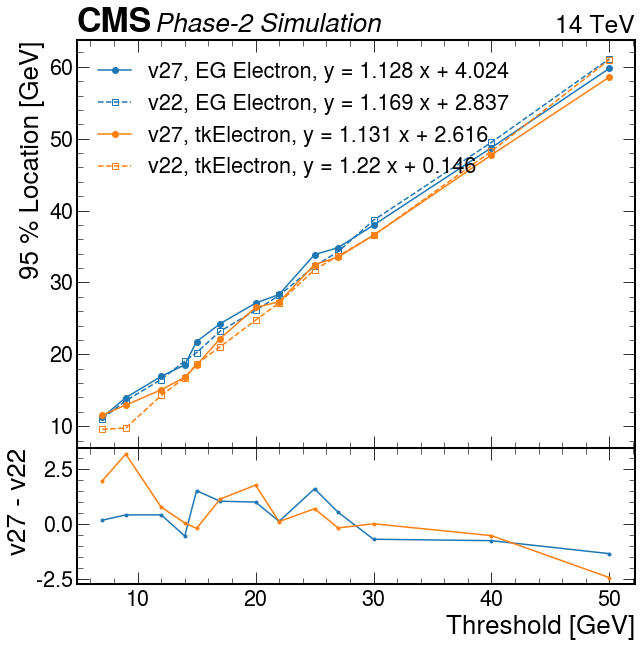

In [29]:
f = comp_scalings(plot1,plot2, sfxs = ["v27","v22"], lss = ["-","--"])

In [32]:
import awkward as ak

In [33]:
a = ak.from_parquet("/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/alobanov/phase2/menu/ntuples/cache/V29_13X/V29_13X_ZEE_tkElectron.parquet")

In [34]:
a

<Array [[], ... tkElectronPassesPhoID: 0}]] type='9000 * var * {"tkElectronPt": ...'>

In [24]:
v0_jsons

['/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V33nano/object_performance/rates/V33nano_Offline_EGRates.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V33nano/object_performance/rates/V33nano_Offline_HTRates.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V33nano/object_performance/rates/V33nano_Offline_JetDefaultRates.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V33nano/object_performance/rates/V33nano_Offline_JetSC8Rates.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V33nano/object_performance/rates/V33nano_Offline_JetSC8Rates_byRegion.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V33nano/object_performance/rates/V33nano_Offline_JetSC8Rates_byRegion2.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V33nano/object_performance/rates/V33nano_Offline_JetsByRegion.json',
 '/eos/user/a/alobanov/www/L1T/Phase2/m

In [26]:
! ls -lsrt /eos/user/a/alobanov/www/L1T/Phase2/menu/Validation/NewMenuTools/V33nano/object_performance/turnons/

total 12720
  1 -rw-r--r--. 1 alobanov 1399    189 Mar  3 15:53 EGRates.yaml
 76 -rw-r--r--. 1 alobanov 1399  77607 Mar  5 12:26 ElectronsIsolation_Barrel_-999_V33nano.png
 23 -rw-r--r--. 1 alobanov 1399  23179 Mar  5 12:26 ElectronsIsolation_Barrel_-999_V33nano.pdf
 12 -rw-r--r--. 1 alobanov 1399  12197 Mar  5 12:26 ElectronsIsolation_Barrel_-999_V33nano.json
  1 -rw-r--r--. 1 alobanov 1399    498 Mar  5 12:26 ElectronsIsolation_Barrel_-999_V33nano.yaml
 79 -rw-r--r--. 1 alobanov 1399  80731 Mar  5 12:26 ElectronsIsolation_Endcap_-999_V33nano.png
 23 -rw-r--r--. 1 alobanov 1399  23481 Mar  5 12:26 ElectronsIsolation_Endcap_-999_V33nano.pdf
 12 -rw-r--r--. 1 alobanov 1399  12222 Mar  5 12:26 ElectronsIsolation_Endcap_-999_V33nano.json
  1 -rw-r--r--. 1 alobanov 1399    502 Mar  5 12:26 ElectronsIsolation_Endcap_-999_V33nano.yaml
132 -rw-r--r--. 1 alobanov 1399 134322 Mar  5 12:26 ElectronsMatching_Eta_Pt10to25_-999_V33nano.png
 30 -rw-r--r--. 1 alobanov 1399  29969 Mar  5 12:26 Electro